## 📦 **Import Libraries**

In [2]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.7 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🗃️ **Data Preparation**

In [5]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

projects = pd.read_csv(dir + 'projects_remove_stopwords_only.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [6]:
projects.head()

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis tinggal apartemen jakarta menulis 1 ar...,7.0,['Writing'],250000.0
1,1,membuat artikel media online pekerjaan membuat...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video konten tiktok hi ada 1...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element template punya...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi app store sedang men...,7.0,['iPhone/iOS'],150000.0


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

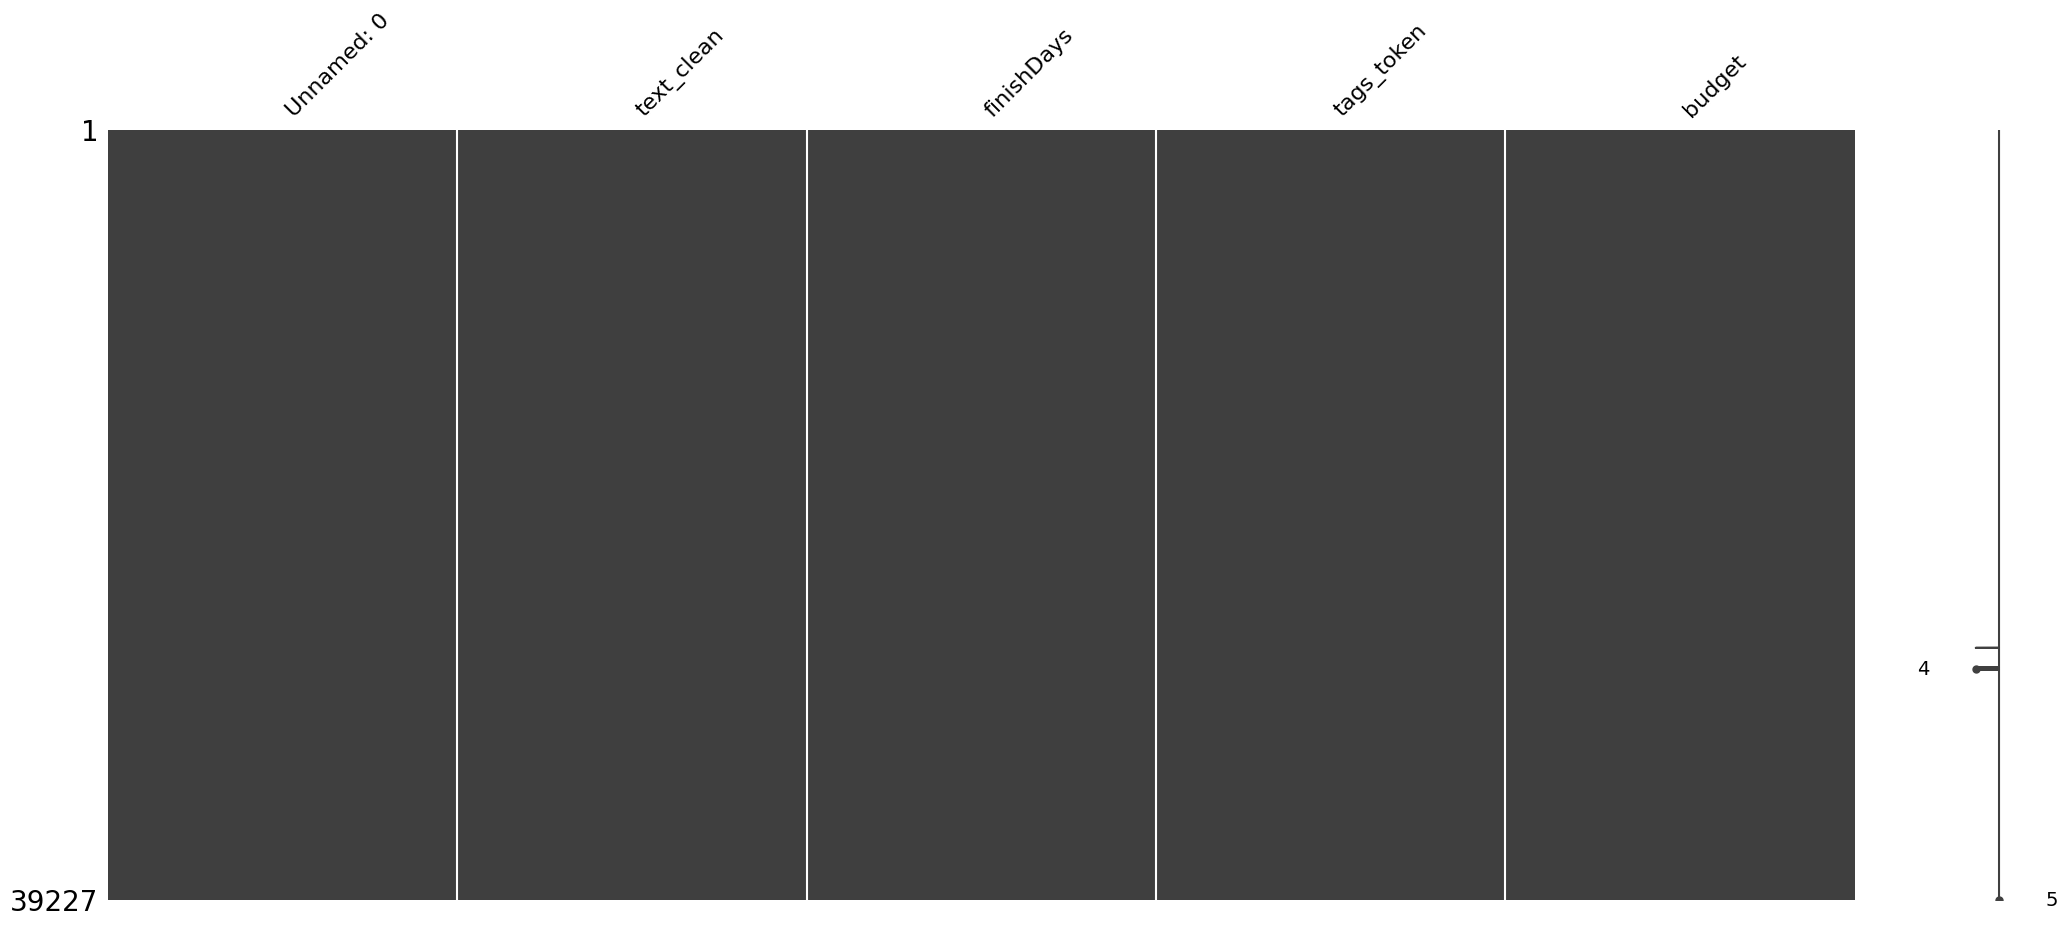

In [7]:
msno.matrix(projects)
plt.show()

In [8]:
round(projects.isna().mean().sort_values(ascending = False), 4)

text_clean    0.0001
Unnamed: 0    0.0000
finishDays    0.0000
tags_token    0.0000
budget        0.0000
dtype: float64

In [9]:
df = projects

In [10]:
df

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis tinggal apartemen jakarta menulis 1 ar...,7.0,['Writing'],250000.0
1,1,membuat artikel media online pekerjaan membuat...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video konten tiktok hi ada 1...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element template punya...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi app store sedang men...,7.0,['iPhone/iOS'],150000.0
...,...,...,...,...,...
39222,39222,terjemahkan bahasa inggris bahasa indonesia te...,7.0,['English'],600000.0
39223,39223,buatkan lagu buatkan lagu genre anak anak dura...,7.0,['Cakewalk'],800000.0
39224,39224,pembuatan banner promosi produk ukuran 336x280...,5.0,['Graphic Design'],600000.0
39225,39225,edit foto editkan foto dan ingin hasil foto di...,3.0,['Adobe PhotoShop'],250000.0


In [11]:
df.rename(columns = {'tags_token':'project_tags'}, inplace = True)

##`project_tags`

In [16]:
# Filtering the rare terms.
df_filtered = df.groupby("project_tags").filter(lambda x: len(x) > 1)
df_filtered['project_tags']

0                                              ['Writing']
3        ['Design Arts', 'Graphic Design', 'Logo Design...
4                                           ['iPhone/iOS']
5                                              ['Writing']
6                 ['Data Entry', 'Quesioner', 'Responden']
                               ...                        
39221                                  ['Email Marketing']
39222                                          ['English']
39224                                   ['Graphic Design']
39225                                  ['Adobe PhotoShop']
39226                     ['CorelDRAW', 'Adobe PhotoShop']
Name: project_tags, Length: 27838, dtype: object

In [17]:
import ast 

df_filtered['project_tags'] = [ast.literal_eval(i) for i in df_filtered['project_tags']]
df_filtered['project_tags'].values[:5]

array([list(['Writing']),
       list(['Design Arts', 'Graphic Design', 'Logo Design', 'Canva']),
       list(['iPhone/iOS']), list(['Writing']),
       list(['Data Entry', 'Quesioner', 'Responden'])], dtype=object)

In [19]:
df_filtered = df_filtered.drop('Unnamed: 0', axis = 1)

In [25]:
df_filtered['text'] = df_filtered['text_clean']
df_filtered['text'] = df_filtered['text'].astype(str)

## Base Model

In [26]:
df_filtered

,text_clean,finishDays,project_tags,budget,text
0,penulis tinggal apartemen jakarta menulis 1 ar...,7.0,[Writing],250000.0,penulis tinggal apartemen jakarta menulis 1 ar...
3,cari akun canva creator element template punya...,7.0,"[Design Arts, Graphic Design, Logo Design, Canva]",1000000.0,cari akun canva creator element template punya...
4,cari jasa upload aplikasi app store sedang men...,7.0,[iPhone/iOS],150000.0,cari jasa upload aplikasi app store sedang men...
5,membutuhkan penulis artikel zodiac disebutan b...,10.0,[Writing],200000.0,membutuhkan penulis artikel zodiac disebutan b...
6,penyebaran kuesioner sleman membutuhkan jasa p...,3.0,"[Data Entry, Quesioner, Responden]",150000.0,penyebaran kuesioner sleman membutuhkan jasa p...
...,...,...,...,...,...
39221,data email kumpulkan data data email perusahaa...,12.0,[Email Marketing],1000000.0,data email kumpulkan data data email perusahaa...
39222,terjemahkan bahasa inggris bahasa indonesia te...,7.0,[English],600000.0,terjemahkan bahasa inggris bahasa indonesia te...
39224,pembuatan banner promosi produk ukuran 336x280...,5.0,[Graphic Design],600000.0,pembuatan banner promosi produk ukuran 336x280...
39225,edit foto editkan foto dan ingin hasil foto di...,3.0,[Adobe PhotoShop],250000.0,edit foto editkan foto dan ingin hasil foto di...


In [27]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["project_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 25054
Number of rows in validation set: 1392
Number of rows in test set: 1392


In [28]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    25054.000000
mean        47.147561
std         24.018944
min          1.000000
25%         28.000000
50%         45.000000
75%         64.000000
max        394.000000
Name: text, dtype: float64

In [29]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [30]:
terms = tf.ragged.constant(train_df["project_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Writing', 'PHP', 'Content Writer', 'Copywriter', 'Wordpress', 'Adobe PhotoShop', 'Data Entry', 'Search Engine Optimization (SEO)', 'Blog', 'Graphic Design', 'Web Programming', 'MySQL', 'Website', 'CodeIgniter', 'CorelDRAW', 'Android', 'Adobe Illustrator', 'Microsoft Word', 'HTML', 'Wordpress Templates', 'Laravel Framework', 'Logo Design', 'Web Design', 'CSS', 'Android studio', 'Internet Marketing', 'JavaScript', 'Website Building', 'Blogspot', 'Mobile Programming', 'Website Templates', 'Social Media Marketing (SMM)', 'English', 'Microsoft Excel', 'Video Editing', 'Video Production', 'Design Arts', 'Translation', 'Bootstrap', 'Market Research', 'Python', 'Web Research', 'Java', 'Web Scrapping', 'Instagram', 'Screenwriting', 'jQuery', 'Administration', 'Adobe Indesign', 'WooCommerce', 'Data Mining', 'Corel PhotoPaint', 'Facebook', 'E-Commerce', 'Data Analysis', 'Adobe Premiere', 'Adobe After Effects', 'Youtube', 'CSS Templates', 'Microsoft Office', 'Database Progr

In [31]:
sample_label = train_df["project_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Administrative Support', 'Internet Marketing', 'Administration']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [32]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["project_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [33]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [34]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'dibutuhkan penulis artikel teknologi dibutuhkan penulis membuat artikel konten berupa pengetahuan umum syarat original bukan copas hasil translate dilarang spin ketentuan 3 artikel minumum 1000 1300 kata keterangan disarankan paham mengenai jaringan artikel akan dibuat jaringan komputer topologi jaringan anda ingin berkontribusi publikasi kontenpengetahuan dibutuhkan para pelajar indonesia'
Label(s): ['Content Writer']
 
Text: b'membuat proposal sponsor team esport waktu pembuatan 2 hari membuat proposal sponsor menarik menjelaskan esport apa esport besar indonesia keuntungan sponsor di dan lain2 membuat calon sponsor tertarik menggunakan tata bahasa bagus perlu banyak halaman cukup simple'
Label(s): ['Writing' 'Business Document Translation' 'Business Service'
 'Business Proposals' 'Business Analysis' 'Business Plans'
 'Business Consultation']
 
Text: b'tambah product item halaman checkout woocommerce membutuhkan source code menambahkan product item halaman checkout woocommerc

In [35]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

38626


In [36]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [39]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [40]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
196/196 [==============================] - 11s 20ms/step - loss: 0.0596 - binary_accuracy: 0.9800 - val_loss: 0.0197 - val_binary_accuracy: 0.9945
Epoch 2/20
196/196 [==============================] - 4s 21ms/step - loss: 0.0131 - binary_accuracy: 0.9959 - val_loss: 0.0175 - val_binary_accuracy: 0.9950
Epoch 3/20
196/196 [==============================] - 5s 26ms/step - loss: 0.0066 - binary_accuracy: 0.9978 - val_loss: 0.0199 - val_binary_accuracy: 0.9951
Epoch 4/20
196/196 [==============================] - 4s 22ms/step - loss: 0.0040 - binary_accuracy: 0.9988 - val_loss: 0.0228 - val_binary_accuracy: 0.9950
Epoch 5/20
196/196 [==============================] - 3s 17ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.0252 - val_binary_accuracy: 0.9949
Epoch 6/20
196/196 [==============================] - 4s 23ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.0269 - val_binary_accuracy: 0.9949
Epoch 7/20
196/196 [==============================] - 4s 

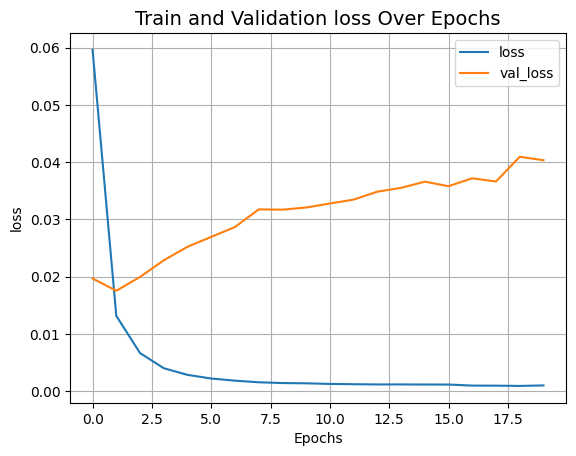

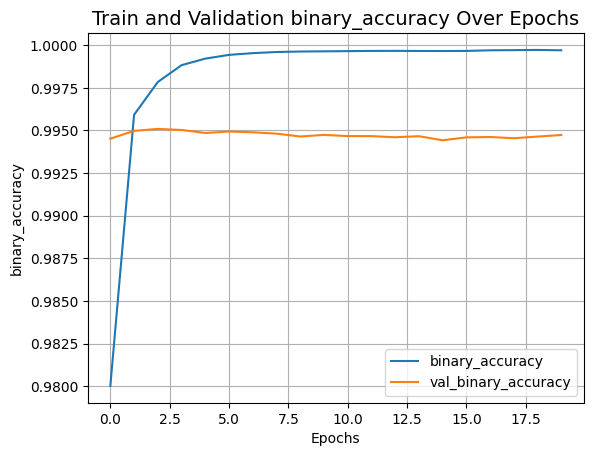

In [41]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [42]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 0s 13ms/step - loss: 0.0384 - binary_accuracy: 0.9948
Categorical accuracy on the test set: 99.48%.


In [43]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 5ms/step
Text: b'jasa sebar kuesioner disertasi commerce online seluruh indonesia part 7 semuanya ini sedang melakukan penelitian sedang berada tahapan pencarian responden membutuhkan tenaga menyebarkan kuesioner kepada individu seluruh indonesia adapun kriteria responden saya cari berdomisili indonesia responden berusia minimal 16 77 tahun pernah melakukan kegiatan belanja online salah satu commerce platform contoh tokopedia shopee id dalam kurun waktu 3 tiga bulan terakhir pernah menggunakan minimal 2 commerce platform berbeda'
Label(s): ['Data Entry' 'Internet Marketing' 'Social Media Marketing (SMM)'
 'Market Research' 'E-Commerce' 'Internet Campaign']
Predicted Label(s): (Internet Marketing, Market Research, Social Media Marketing (SMM), Internet Campaign, Data Entry)
 
Text: b'tender mmii perlu dibuatkan lay out 3d event dan harus submit maksimal hari senin kalau saya di hari minggu lay out 2 dimensi saya berikan via wa'
Label(s): ['3D Re